In [18]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from sklearn.utils import class_weight
import matplotlib.pyplot as plt

In [19]:
# Data Preparation
train_dir = "../../data5/train"
test_dir = "../../data5/test"
batch_size = 32
image_size = (224, 224)

# Reduced Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=15,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,  
    height_shift_range=0.1,
    shear_range=0.1,
    fill_mode="nearest"
)

validation_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

num_classes = train_generator.num_classes

# Compute Class Weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))


Found 5999 images belonging to 4 classes.
Found 2576 images belonging to 4 classes.


In [3]:
# Standalone ResNet50 Model
def build_resnet50_model(num_classes):
    resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    resnet_base.trainable = False  # Freeze base model

    input_tensor = Input(shape=(224, 224, 3))
    x = resnet_base(input_tensor)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    output_tensor = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_tensor, outputs=output_tensor)
    return model

model = build_resnet50_model(num_classes)

# Learning Rate Scheduler
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.001, decay_steps=1000, alpha=0.00001
)

model.compile(optimizer=Adam(learning_rate=lr_schedule), loss='categorical_crossentropy', metrics=['accuracy', 'AUC'])

In [4]:
# Train the ResNet50 Model
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=5, min_lr=1e-6)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    verbose=1,
    class_weight=class_weights,
    callbacks=[early_stopping, lr_scheduler]
)

# Save the trained model
model.save("../../models/Improved_resnet50_7030_model.keras")

Epoch 1/20


/Users/liraj/.pyenv/versions/3.9.4/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


188/188 ━━━━━━━━━━━━━━━━━━━━ 289s 2s/step - AUC: 0.6833 - accuracy: 0.4251 - loss: 1.2914 - val_AUC: 0.6328 - val_accuracy: 0.4161 - val_loss: 1.3390 - learning_rate: 9.1530e-04
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 289s 2s/step - AUC: 0.7831 - accuracy: 0.5361 - loss: 1.0995 - val_AUC: 0.7410 - val_accuracy: 0.4790 - val_loss: 1.2540 - learning_rate: 6.8989e-04
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 277s 1s/step - AUC: 0.8035 - accuracy: 0.5472 - loss: 1.0422 - val_AUC: 0.8274 - val_accuracy: 0.5924 - val_loss: 1.0512 - learning_rate: 4.0015e-04
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 275s 1s/step - AUC: 0.8273 - accuracy: 0.5883 - loss: 0.9863 - val_AUC: 0.8443 - val_accuracy: 0.6033 - val_loss: 0.9524 - learning_rate: 1.4424e-04
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 291s 2s/step - AUC: 0.8284 - accuracy: 0.5820 - loss: 0.9832 - val_AUC: 0.8482 - val_accuracy: 0.6083 - val_loss: 0.9332 - learning_rate: 8.8663e-06
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 284s 2s/step - AUC: 0.8220

81/81 ━━━━━━━━━━━━━━━━━━━━ 81s 997ms/step - AUC: 0.8477 - accuracy: 0.6071 - loss: 0.9380
Validation Loss: 0.93
Validation Accuracy: 0.61
81/81 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step
                 precision    recall  f1-score   support

1. Enfeksiyonel       0.28      0.33      0.30       650
      2. Ekzama       0.24      0.28      0.26       650
        3. Akne       0.24      0.19      0.21       626
      4. Malign       0.27      0.23      0.25       650

       accuracy                           0.26      2576
      macro avg       0.26      0.26      0.26      2576
   weighted avg       0.26      0.26      0.26      2576

[[213 173 126 138]
 [196 184 134 136]
 [179 207 121 119]
 [182 198 121 149]]


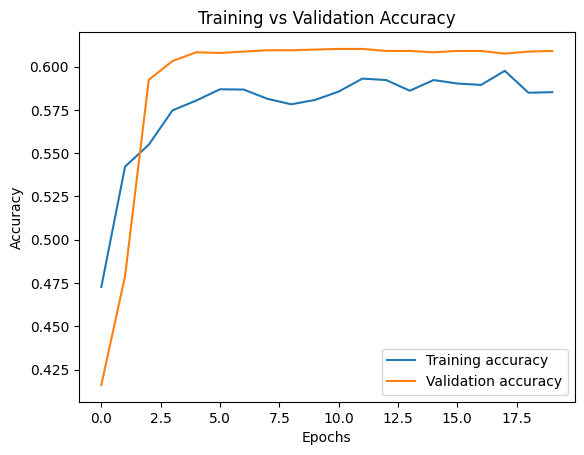

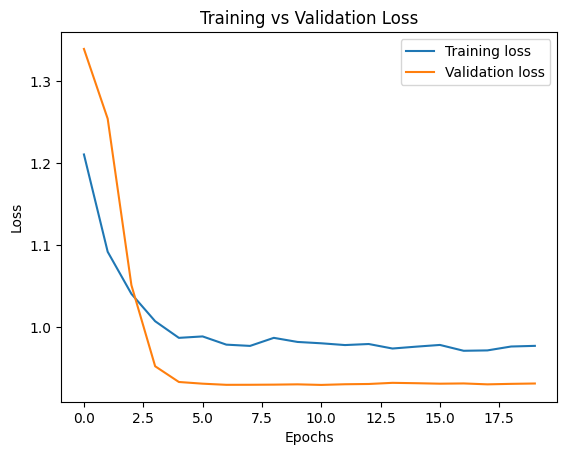

In [5]:
# Evaluate the ResNet50 Model
results = model.evaluate(validation_generator)
print(f"Validation Loss: {results[0]:.2f}")
print(f"Validation Accuracy: {results[1]:.2f}")

# Classification report and confusion matrix
val_preds = np.argmax(model.predict(validation_generator), axis=1)
true_labels = validation_generator.classes
print(classification_report(true_labels, val_preds, target_names=validation_generator.class_indices.keys()))
print(confusion_matrix(true_labels, val_preds))

# Plot training and validation curves
def plot_training_results(history, metrics=["accuracy", "loss"]):
    for metric in metrics:
        plt.figure()
        plt.plot(history.history[metric], label=f"Training {metric}")
        plt.plot(history.history[f"val_{metric}"], label=f"Validation {metric}")
        plt.title(f"Training vs Validation {metric.capitalize()}")
        plt.xlabel("Epochs")
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.show()

plot_training_results(history, metrics=["accuracy", "loss"])

Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1044s 5s/step - AUC: 0.5822 - accuracy: 0.3134 - loss: 1.3566 - val_AUC: 0.4957 - val_accuracy: 0.2430 - val_loss: 1.3928 - learning_rate: 1.0000e-04
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 2102s 11s/step - AUC: 0.7031 - accuracy: 0.4203 - loss: 1.2716 - val_AUC: 0.5016 - val_accuracy: 0.2492 - val_loss: 1.4043 - learning_rate: 1.0000e-04
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1030s 5s/step - AUC: 0.7280 - accuracy: 0.4284 - loss: 1.2139 - val_AUC: 0.5299 - val_accuracy: 0.2523 - val_loss: 1.4122 - learning_rate: 1.0000e-04
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1141s 6s/step - AUC: 0.7311 - accuracy: 0.4375 - loss: 1.1942 - val_AUC: 0.6719 - val_accuracy: 0.3715 - val_loss: 1.2936 - learning_rate: 1.0000e-04
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1137s 6s/step - AUC: 0.7361 - accuracy: 0.4290 - loss: 1.1666 - val_AUC: 0.7794 - val_accuracy: 0.4794 - val_loss: 1.1562 - learning_rate: 1.0000e-04
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1031s 5s/

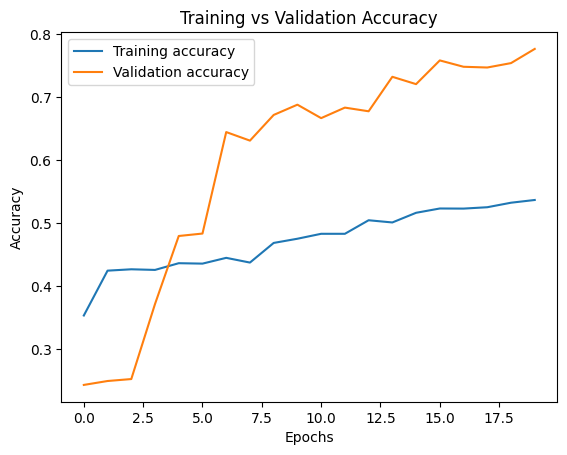

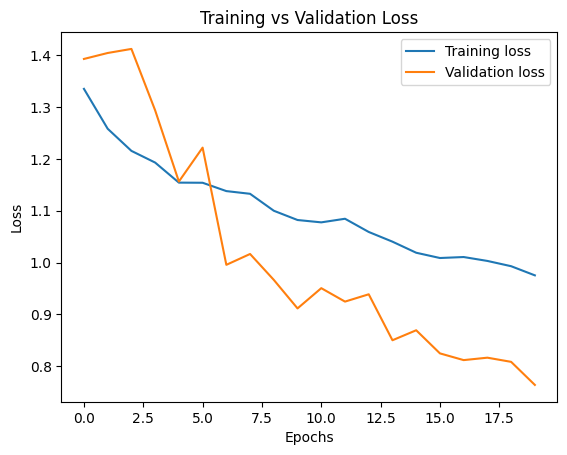

In [6]:
# Unfreeze the last few layers of the original model
for layer in model.layers[-10:]:
    layer.trainable = True  # Enable training for the last 10 layers

# Add dropout layers to the fully connected part of the model
x = model.output
x = Dropout(0.5)(x)  # Add dropout before the final dense layers
x = Dense(256, activation='relu')(x)  # Add an extra dense layer for better representation
x = Dropout(0.5)(x)  # Add another dropout layer
predictions = Dense(num_classes, activation='softmax')(x)  # Final output layer

# Create a new model
dropout_model = Model(inputs=model.input, outputs=predictions)

# Compile the model with a lower learning rate for fine-tuning
dropout_model.compile(
    optimizer=Adam(learning_rate=1e-4), 
    loss='categorical_crossentropy', 
    metrics=['accuracy', 'AUC']
)

# Fine-tune the model
fine_tune_history = dropout_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    batch_size=32,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
    ]
)

# Save the fine-tuned model
dropout_model.save("../../models/Improved_resnet50_6040_model.keras")

# Plot training results
def plot_training_results(history, metrics=["accuracy", "loss"]):
    for metric in metrics:
        plt.figure()
        plt.plot(history.history[metric], label=f"Training {metric}")
        plt.plot(history.history[f"val_{metric}"], label=f"Validation {metric}")
        plt.title(f"Training vs Validation {metric.capitalize()}")
        plt.xlabel("Epochs")
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.show()

plot_training_results(fine_tune_history, metrics=["accuracy", "loss"])

In [14]:
# Evaluate the ResNet50 Model
results = dropout_model.evaluate(validation_generator)
print(f"Validation Loss: {results[0]:.2f}")
print(f"Validation Accuracy: {results[1]:.2f}")


81/81 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - AUC: 0.9307 - accuracy: 0.7707 - loss: 0.7732
Validation Loss: 0.76
Validation Accuracy: 0.78


In [15]:
# Evaluate the ResNet50 Model
results_acc = dropout_model.evaluate(train_generator)
print(f"Training Loss: {results_acc[0]:.2f}")
print(f"Training Accuracy: {results_acc[1]:.2f}")


188/188 ━━━━━━━━━━━━━━━━━━━━ 266s 1s/step - AUC: 0.9513 - accuracy: 0.8237 - loss: 0.7137
Validation Loss: 0.71
Validation Accuracy: 0.83


81/81 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step


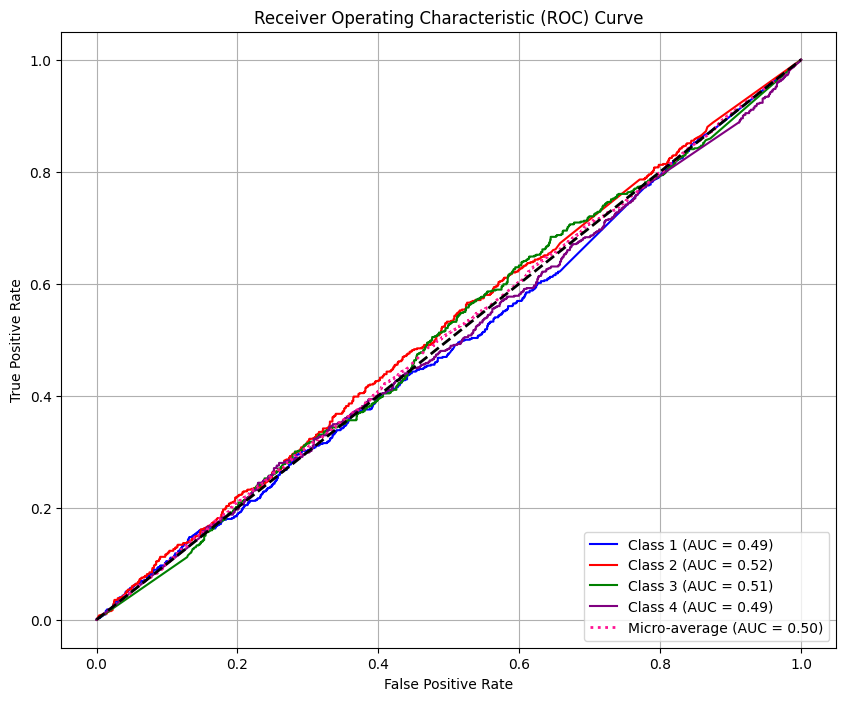

In [8]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Assuming you already have `validation_generator` and the model
# Generate predictions
y_true = validation_generator.classes
y_pred = dropout_model.predict(validation_generator)

# Binarize the true labels for multi-class ROC
y_true_binarized = label_binarize(y_true, classes=np.arange(num_classes))

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_binarized.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'purple', 'orange']  # Use distinct colors for each class
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i % len(colors)],
             label=f"Class {i + 1} (AUC = {roc_auc[i]:.2f})")

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f"Micro-average (AUC = {roc_auc['micro']:.2f})",
         color='deeppink', linestyle=':', linewidth=2)

# Plot diagonal line for random guessing
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Customize the plot
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()


188/188 ━━━━━━━━━━━━━━━━━━━━ 242s 1s/step


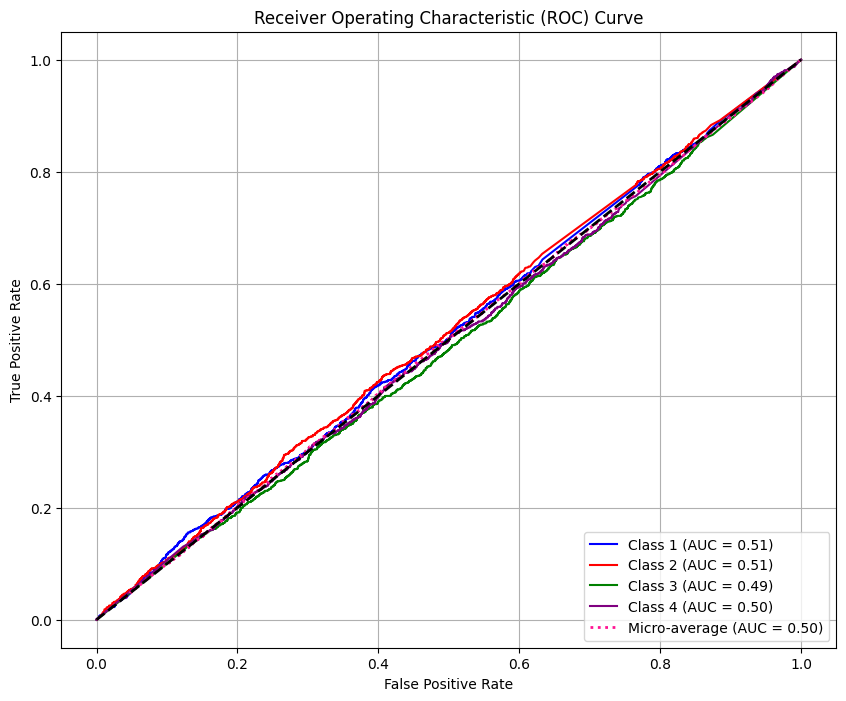

In [12]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Generate predictions
x_true = train_generator.classes
x_pred = dropout_model.predict(train_generator)

# Binarize the true labels for multi-class ROC
x_true_binarized = label_binarize(x_true, classes=np.arange(num_classes))

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(x_true_binarized[:, i], x_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(x_true_binarized.ravel(), x_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'purple', 'orange']  # Use distinct colors for each class
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i % len(colors)],
             label=f"Class {i + 1} (AUC = {roc_auc[i]:.2f})")

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f"Micro-average (AUC = {roc_auc['micro']:.2f})",
         color='deeppink', linestyle=':', linewidth=2)

# Plot diagonal line for random guessing
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Customize the plot
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [16]:
# Classification report and confusion matrix
val_preds = np.argmax(dropout_model.predict(train_generator), axis=1)
true_labels = train_generator.classes
print(classification_report(true_labels, val_preds, target_names=train_generator.class_indices.keys()))
print(confusion_matrix(true_labels, val_preds))

188/188 ━━━━━━━━━━━━━━━━━━━━ 264s 1s/step
                 precision    recall  f1-score   support

1. Enfeksiyonel       0.26      0.25      0.25      1500
      2. Ekzama       0.24      0.24      0.24      1500
        3. Akne       0.25      0.28      0.26      1499
      4. Malign       0.26      0.25      0.25      1500

       accuracy                           0.25      5999
      macro avg       0.25      0.25      0.25      5999
   weighted avg       0.25      0.25      0.25      5999

[[370 404 376 350]
 [361 354 415 370]
 [366 369 413 351]
 [344 343 439 374]]


81/81 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step
Classification Report:
                 precision    recall  f1-score   support

1. Enfeksiyonel       0.25      0.25      0.25       650
      2. Ekzama       0.25      0.23      0.24       650
        3. Akne       0.24      0.26      0.25       626
      4. Malign       0.25      0.26      0.25       650

       accuracy                           0.25      2576
      macro avg       0.25      0.25      0.25      2576
   weighted avg       0.25      0.25      0.25      2576

Confusion Matrix:
[[161 138 183 168]
 [161 151 171 167]
 [150 153 163 160]
 [161 152 170 167]]


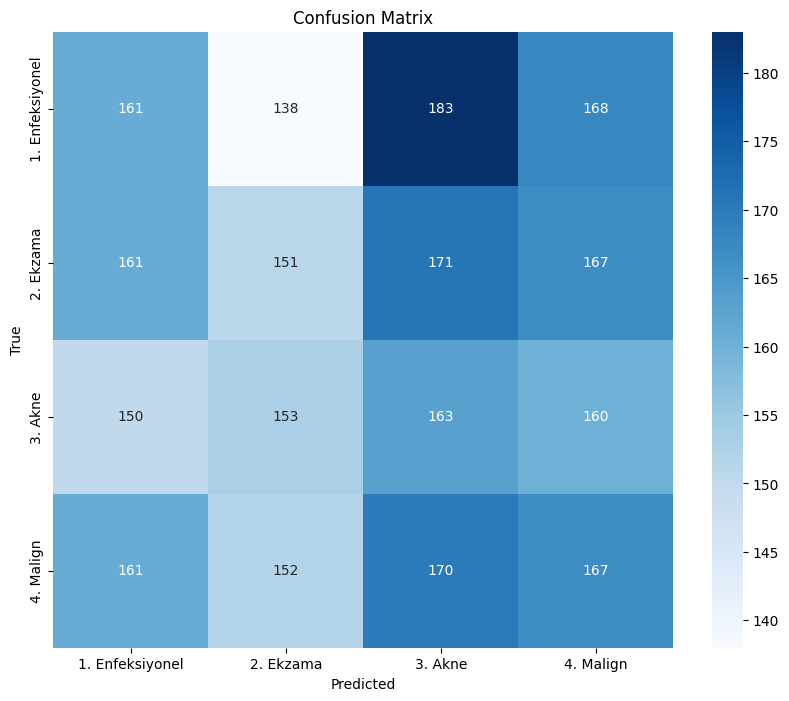

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Generate predictions for the validation set
val_preds = np.argmax(model.predict(validation_generator), axis=1)  # Predicted class indices
true_labels = validation_generator.classes  # True class indices

# Get class names from the validation generator
class_names = list(validation_generator.class_indices.keys())

# Classification report
print("Classification Report:")
print(classification_report(true_labels, val_preds, target_names=class_names))

# Confusion matrix
print("Confusion Matrix:")
conf_matrix = confusion_matrix(true_labels, val_preds)
print(conf_matrix)

# Optionally: Visualize the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [9]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline

def plot_roc_curve(y_true, y_pred, num_classes, class_names=None, smooth=False):
    """
    Plots a multi-class ROC curve with optional smoothing and enhanced visuals.

    Parameters:
    - y_true: Ground truth labels.
    - y_pred: Predicted probabilities for each class.
    - num_classes: Total number of classes.
    - class_names: Optional list of class names.
    - smooth: Whether to smooth the ROC curves.
    """
    # Binarize true labels
    y_true_binarized = label_binarize(y_true, classes=np.arange(num_classes))

    # Initialize dictionaries
    fpr = {}
    tpr = {}
    roc_auc = {}

    # Compute ROC curve and AUC for each class
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Micro-average ROC curve and AUC
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_binarized.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot settings
    plt.figure(figsize=(12, 8))
    cmap = plt.get_cmap("tab10")

    for i in range(num_classes):
        color = cmap(i % 10)  # Use colormap for dynamic coloring
        if smooth:
            # Smoothing the curve for better visuals
            x_new = np.linspace(fpr[i].min(), fpr[i].max(), 200)
            tpr_smooth = make_interp_spline(fpr[i], tpr[i])(x_new)
            plt.plot(x_new, tpr_smooth, label=f"Class {class_names[i] if class_names else i} (AUC = {roc_auc[i]:.2f})", color=color)
        else:
            plt.plot(fpr[i], tpr[i], label=f"Class {class_names[i] if class_names else i} (AUC = {roc_auc[i]:.2f})", color=color)

    # Micro-average
    plt.plot(fpr["micro"], tpr["micro"], label=f"Micro-average (AUC = {roc_auc['micro']:.2f})", color="deeppink", linestyle=":", linewidth=2)

    # Diagonal line
    plt.plot([0, 1], [0, 1], "k--", lw=2)

    # Labels and title
    plt.title("Multi-Class Receiver Operating Characteristic (ROC) Curve", fontsize=16)
    plt.xlabel("False Positive Rate", fontsize=14)
    plt.ylabel("True Positive Rate", fontsize=14)
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Example usage
y_true = validation_generator.classes 
y_pred = dropout_model.predict(validation_generator) 
plot_roc_curve(y_true, y_pred, num_classes=4, class_names=["Fungal Infections", "Ecezma", "Acne", "Malign"], smooth=True)


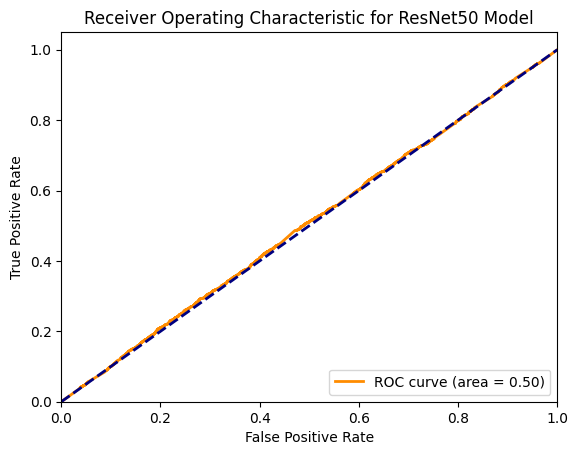

In [10]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for ResNet50 Model')
plt.legend(loc="lower right")
plt.show()